In [1]:
from scipy.io import wavfile
from scipy import signal as ss
import numpy as np
import matplotlib.pyplot as plt

In [264]:
from yin_detection import *
%load_ext line_profiler

In [281]:
def optimized_calculaitons(f, W, t, sample_rate, bounds, th=0.1, p_energy=0, p_freq=1):
    energy_array = np.array(f[t:t+W+bounds[1]+1]*f[t:t+W+bounds[1]+1], dtype=float).cumsum()
    energy_2_array = (energy_array[W:W+bounds[1]+1]-energy_array[:bounds[1]+1]).cumsum()
    #autocorrelation = np.array([np.sum(f[t: t+W] * f[t+i:i+t+W]) for i in range(bounds[1]+1)])
    correlation = ss.correlate(f[t: t+W], f[t: t+W+bounds[1]], mode='full', method='fft')
    autocorrelation = correlation[:-W][::-1][:bounds[1]+1]
    autocorr_sum = autocorrelation[1:].cumsum()
    
    def calc_df(lag):
        return energy_array[W] + (energy_array[W+lag] - energy_array[lag-1]) - 2 * autocorrelation[lag] 
    
    def calc_dmndf(lag):
        if lag == 0:
            return 1
        return calc_df(lag) / (lag * energy_array[W] + energy_2_array[lag] - 2 * autocorr_sum[lag]) * lag# np.sum([calc_df(i) for i in range(1,lag)]) * lag 
    
    curr_energy = energy_array[-1]/(W+bounds[1]+1)**2
    speach = True
    if p_energy > 0:
        if curr_energy < p_energy*0.3:
            speach = False
            curr_energy = p_energy
            return 1, [], curr_energy
    
    CMNDF_vals = np.array([calc_dmndf(i) for i in range(*bounds)])
    sample = None
    if p_freq > 1:
        p_sample = sample_rate/p_freq - bounds[0]
        if p_sample > 0:
            posible_sample = np.argmin(CMNDF_vals[int(p_sample*0.7):int(p_sample*1.3)])+int(p_sample*0.7)
            if CMNDF_vals[posible_sample] < 0.3:
                sample = posible_sample +  bounds[0]
    
    if sample is None:                        
        for i, val in enumerate(CMNDF_vals):
            if val < th: # Get first sample below threshold (first octave)
                sample = i # Check for min near sample.
                subsample = sample
                max_samp = min(int(sample/0.8) - sample, len(CMNDF_vals)-sample-1)           
                for j in range(0,  max_samp):
                    if (CMNDF_vals[sample + j]  < CMNDF_vals[subsample]):
                        subsample = sample + j # New min.
                sample = subsample + bounds[0]
                no_speach = False
                break
    
    if sample is None:
        #posible = np.argmin(CMNDF_vals)+bounds[0]
        sample = sample_rate #if no_speach else posible # Absolute min
    return sample_rate/sample, CMNDF_vals, curr_energy

In [284]:
def fast_pitch_detection(filename, min_freq=20, max_freq=700, window_ms=25, overlap=0, normalize=False):
    sample_rate, data = wavfile.read(filename)
    data = data.astype(np.float64)
    
    if normalize: data = data/np.max(data)
    if len(data.shape)>1: 
        if data.shape[1] > 1: data = data[:,0]
    
    window_size = int(sample_rate*window_ms/1000)

    min_bound = sample_rate // max_freq
    max_bound = sample_rate // min_freq
    bounds = [min_bound, max_bound]
    
    pitches = [0]
    all_cmndfs = []
    energy = 0
    for i in range((data.shape[0]-max_bound) // (window_size*(1-overlap))):
        p, cmndfs, energy = optimized_calculaitons(data, window_size, int(i*window_size/(1-overlap)), sample_rate, bounds, 0.15,p_energy=energy, p_freq=pitches[-1]) 
        pitches.append(p)
        all_cmndfs.append(cmndfs.copy())
    return data, pitches, all_cmndfs

# Tenor audio

In [285]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/tenor.wav")

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_8448/2601579055.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


Wall time: 3.54 s


[]

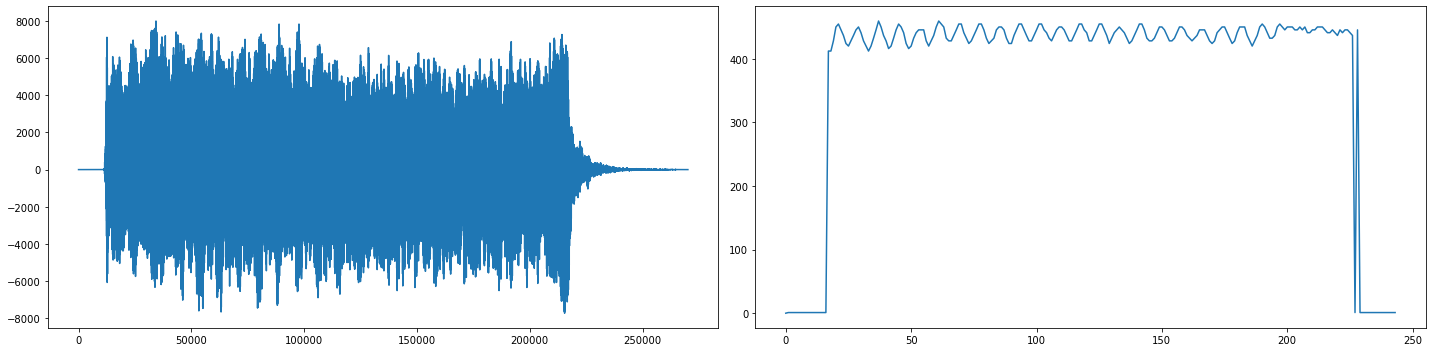

In [286]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# 246.9Hz violin audio

In [287]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/246.9Hz.wav")

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_8448/2601579055.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


Wall time: 549 ms


[]

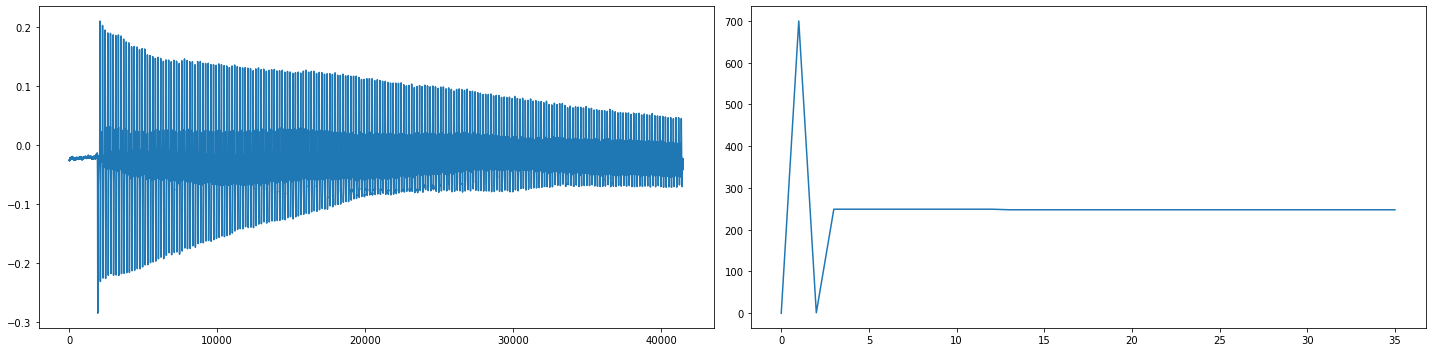

In [288]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# 300Hz audio

In [289]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/300Hz.wav")

Wall time: 5.35 s


[]

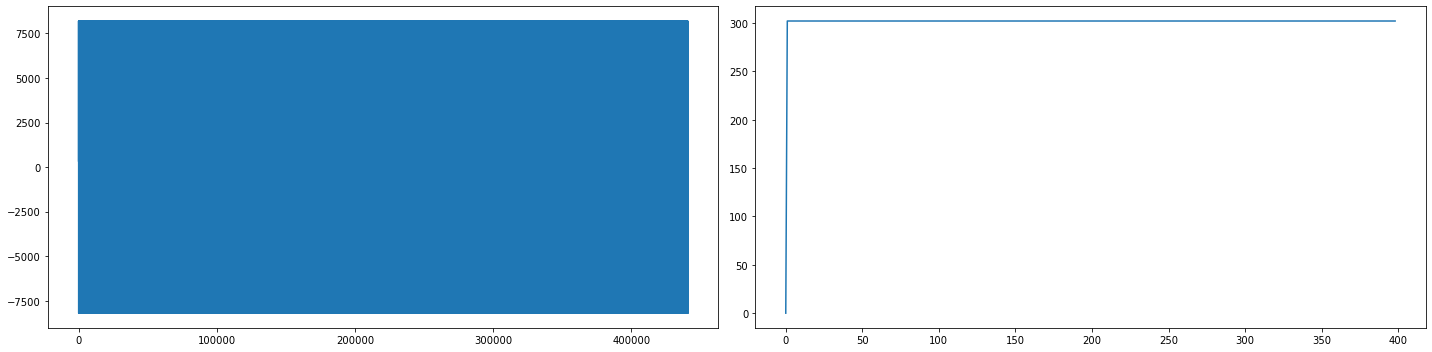

In [290]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# Conversation audio

In [291]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/convesp.wav")

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_8448/3314052993.py:15: RuntimeWarning: invalid value encountered in double_scalars
  return calc_df(lag) / (lag * energy_array[W] + energy_2_array[lag] - 2 * autocorr_sum[lag]) * lag# np.sum([calc_df(i) for i in range(1,lag)]) * lag


Wall time: 5.87 s


[]

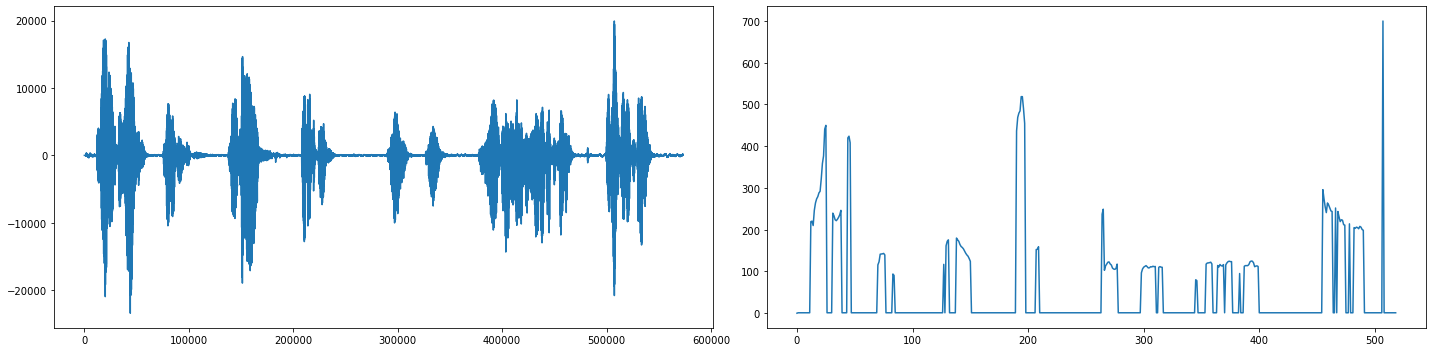

In [292]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# Conversation 2 audio

In [293]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/conversation.wav")

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_8448/3314052993.py:15: RuntimeWarning: invalid value encountered in double_scalars
  return calc_df(lag) / (lag * energy_array[W] + energy_2_array[lag] - 2 * autocorr_sum[lag]) * lag# np.sum([calc_df(i) for i in range(1,lag)]) * lag


Wall time: 3.15 s


[]

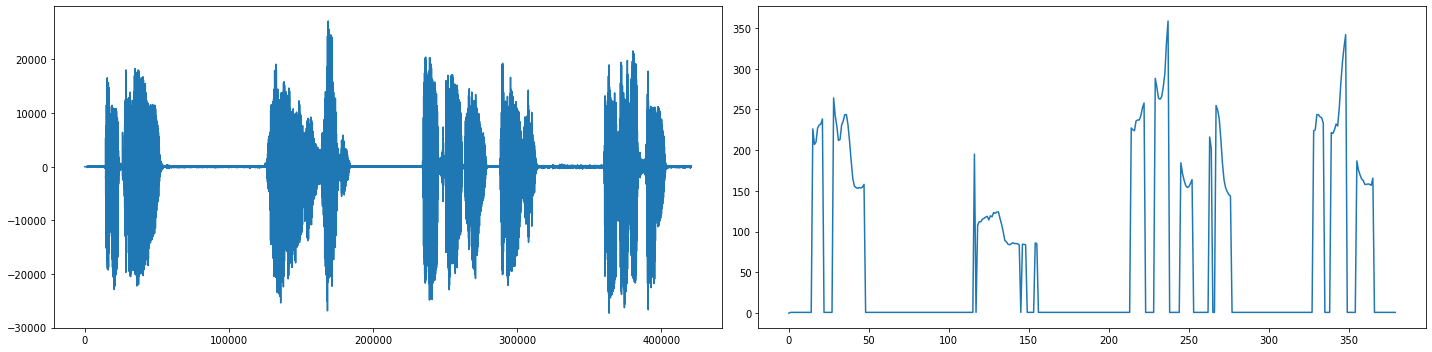

In [294]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()